# Ideas 
This notebook is as an ideas HQ for the GDL project

### Imports

In [1]:
import os
os.chdir('/Users/riccardoconci/Local_documents/ACS submissions/GeomDL/')

In [2]:


from TGB.tgb.utils.info import DATA_URL_DICT
from TGB.tgb.linkproppred.dataset import LinkPropPredDataset

import requests
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import itertools
from itertools import combinations
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr




In [45]:
name = "tgbl-wiki" 
dataset = LinkPropPredDataset(name=name, root="./Datasets", preprocess=True)
type(dataset)
data = dataset.full_data  #a dictioinary stores all the edge data
type(data) 

train_mask = dataset.train_mask
val_mask = dataset.val_mask
test_mask = dataset.test_mask


data_df = pd.DataFrame([data['sources'], data['destinations'], data['timestamps']]).T
data_df.columns = ['Source', 'Destination', 'Timestamp']


raw file found, skipping download
Dataset directory is  /Users/riccardoconci/Local_documents/ACS submissions/GeomDL/TGB/tgb/./Datasets/tgbl_wiki
loading processed file


In [46]:
data_df[data_df['Destination']==8228]


,Source,Destination,Timestamp
1,1.0,8228.0,36.0
2,1.0,8228.0,77.0
4,1.0,8228.0,150.0
7,1.0,8228.0,217.0
11,1.0,8228.0,300.0
...,...,...,...
65531,1.0,8228.0,1158817.0
65535,1.0,8228.0,1158904.0
65546,1.0,8228.0,1159029.0
82567,1.0,8228.0,1421975.0


Now we have the dataset for wiki in a beautiful source, destination, timestamp format...

Things we can look at:

**Network based features**

- What kind of network is it? what do the nodes mean? bipartite

Across the network 
- What is the distribution of user activity? do some users dominate the action?
- What is the distribution of product node activity? are some products way more popular than others?
- What is the general activity  over time? is it relatively stable, or increase, decrease etc. How much of this is dominated by few users doing lots vs many users doing a bit? 

How do these measure change over time?

**For each user**

- Do they pick lots of different products or few? (CDF of unique edges for each user node)


**For each product**

- are popular products popular because lots of people are interested or a few are VERY interested? (CDF of unique edges for each product)


**For each user-product interaction**

- what sort of temporal interactions occur? 
- How many users repeatedly pick on previous products/pages? 
For example do users interact a lot in a short period with one product then drop it, 
or relatively often but for longer period, 
or in periodic (burst of) activity? 

=> CDF of time diff for each source-destination pair
=> Hist of time diff for each source-destination pair 
=> time-destination plot coloured by source 




**Which users behave most similarly?**
how much can one users's activity be explained/predicted by other users?
How independent is the actions of users? are users influenced by other users?



##### NETWORK BASED

**Wikipedia**
stores the co-editing network on Wikipedia pages over one month. The network is a bipartite interaction network where editors and wiki pages are nodes, while one edge represents a given user edits a page at a specific timestamp. Each edge has text features from the page edits.

users 8,227 
items 1,000 
interactions 157,474
state changes 217 : node features, predicting if a user will be banned 
action repetition 61% how repetitive users are (% of users that edit similar pages over time)


Prediction task: The task for this dataset is to predict with which wiki page a user will interact at a given time



<Axes: >

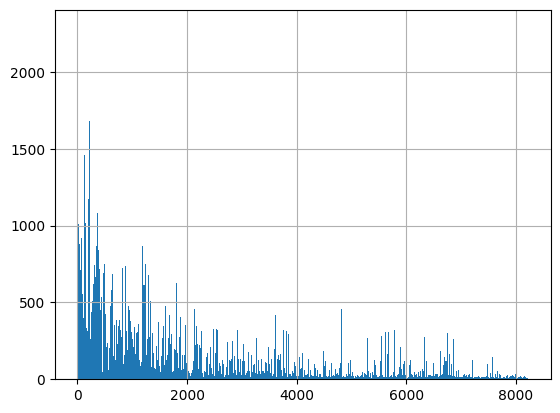

In [7]:
## DISTRIBUTION OF USER ACTIVITY averaged over the FULL TIME 

data_df['Source'].hist(bins=1000)

<Axes: >

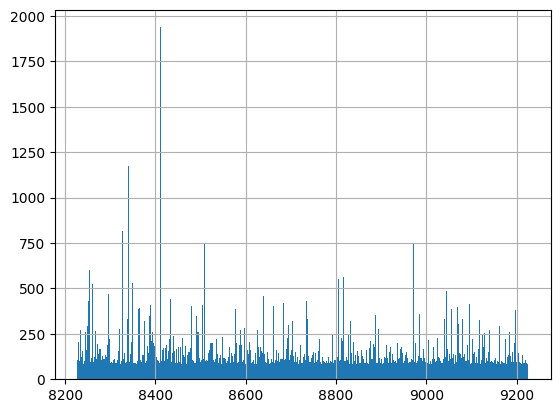

In [8]:
## DISTRIBUTION OF PRODUCT/DESTINATION ACTIVITY averaged over the FULL TIME 

data_df['Destination'].hist(bins=1000)

<Axes: >

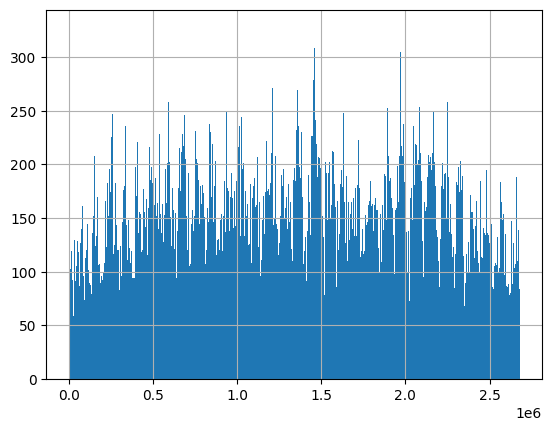

In [9]:
## DISTRIBUTION OF TIME EVENTS 

data_df['Timestamp'].hist(bins=1000)

#### USER BASED
- Do users pick lots of different products or few? How many distinct products are there for each user!?
- What % of users pick n nodes throughout the timeframe?


=> CDF of distinct prodcts per user 
=> histogram of distinct prducts per user 

In [47]:

def plot_cdf(data_df, column_name, log_scale=False, title='CDF Plot', xlabel='Value', ylabel='CDF'):
    """
    Plots the CDF of a specified column in the given DataFrame.
    
    Parameters:
    - data_df: DataFrame containing the data.
    - column_name: The name of the column for which to plot the CDF.
    - log_scale: Whether to use a logarithmic scale for the x-axis. Default is False.
    - title: The title of the plot. Default is 'CDF Plot'.
    - xlabel: The label for the x-axis. Default is 'Value'.
    - ylabel: The label for the y-axis. Default is 'CDF'.
    """
    # Ensure the column exists in the DataFrame
    if column_name not in data_df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    
    # Prepare the data for CDF plot
    sorted_df = data_df.sort_values(by=column_name).reset_index(drop=True)
    sorted_df['cdf'] = sorted_df[column_name].rank(method='average', pct=True)

    # Plotting the CDF
    plt.figure(figsize=(8, 6))
    plt.plot(sorted_df[column_name], sorted_df['cdf'], marker='.', linestyle='none')

    if log_scale:
        plt.xscale('log')  # Set the x-axis to a logarithmic scale

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.show()

# Example usage
# plot_cdf(dest_counts_df, 'UniqueDestCount', log_scale=True, title='CDF of number of events for user-product pair', xlabel='Edge counts for user-product pair', ylabel='CDF')


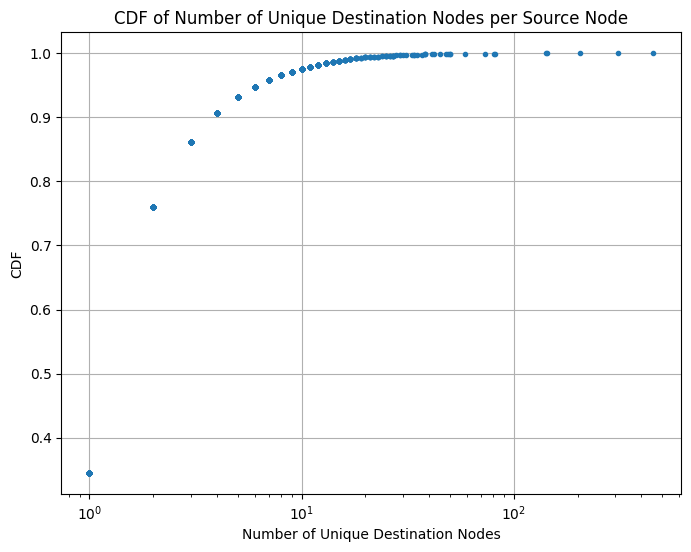

In [48]:
dest_counts_per_source = data_df.groupby('Source')['Destination'].nunique()

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = dest_counts_per_source.reset_index(name='UniqueDestCount')

plot_cdf(dest_counts_df, 'UniqueDestCount', log_scale=True, title='CDF of Number of Unique Destination Nodes per Source Node', xlabel='Number of Unique Destination Nodes', ylabel='CDF')


<Axes: >

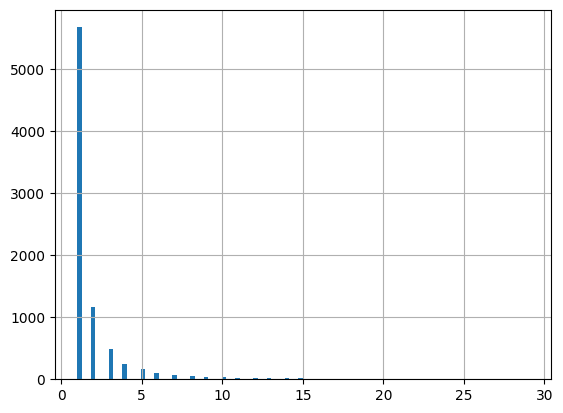

In [49]:

filtered_series = dest_counts_per_source[(dest_counts_per_source >= 1) & (dest_counts_per_source < 30)]

# Plot the histogram with 1000 bins
filtered_series.hist(bins=100)


In [50]:
# Assuming dest_counts_per_source is a Series with the count of unique destinations for each source
percentiles = [0.25, 0.5, 0.75, 0.9, 0.99]
percentile_values = dest_counts_per_source.quantile(percentiles)

print("Percentiles for the Number of Unique Destination Nodes per Source Node:")
print(percentile_values)

# Additional insights
mean = dest_counts_per_source.mean()
std_dev = dest_counts_per_source.std()
max_value = dest_counts_per_source.max()
min_value = dest_counts_per_source.min()

print(f"Mean: {mean}, Std Dev: {std_dev}, Max: {max_value}, Min: {min_value}")


Percentiles for the Number of Unique Destination Nodes per Source Node:
0.25     1.0
0.50     1.0
0.75     2.0
0.90     4.0
0.99    16.0
Name: Destination, dtype: float64
Mean: 2.2191564361249543, Std Dev: 7.6189159339091335, Max: 454, Min: 1


#### PRODUCT BASED
- are popular products popular because lots of people are interested or a few are VERY interested? (CDF of unique edges for each product)


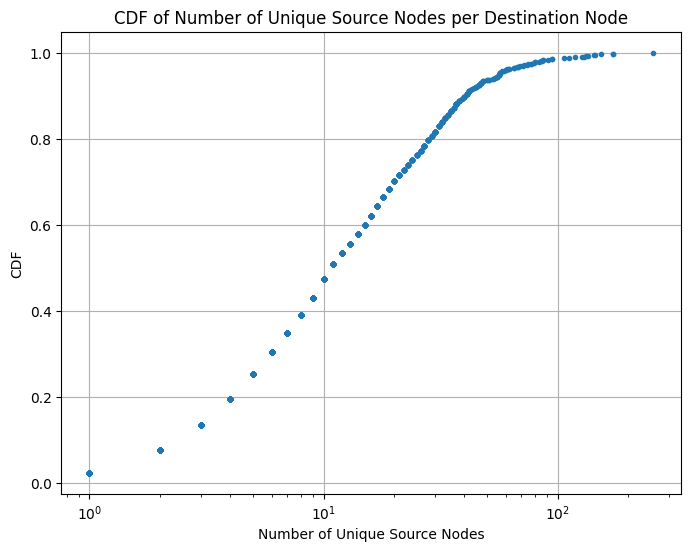

In [51]:
dest_counts_per_destination = data_df.groupby('Destination')['Source'].nunique()

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = dest_counts_per_destination.reset_index(name='UniqueSourceCount')

plot_cdf(dest_counts_df, 'UniqueSourceCount', log_scale=True, title='CDF of Number of Unique Source Nodes per Destination Node', xlabel='Number of Unique Source Nodes', ylabel='CDF')


<Axes: >

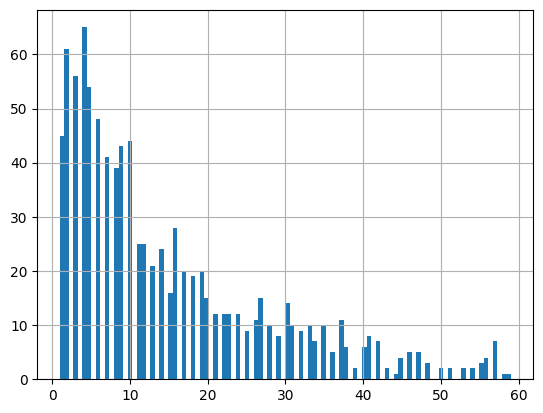

In [52]:

filtered_series = dest_counts_per_destination[(dest_counts_per_destination >= 1) & (dest_counts_per_destination < 60)]

# Plot the histogram with 100 bins
filtered_series.hist(bins=100)



#### For each user-product interaction
what sort of temporal interactions occur? 

- For each user-product pair, what's the distribution of number of interactions?
Do users repeatedly pick on previous products/pages?


For example do users interact a lot in a short period with one product then drop it, 
or relatively often but for longer period, 
or in periodic (burst of) activity? 

=> CDF of time diff for each source-destination pair
=> Hist of time diff for each source-destination pair 
=> time-destination plot coloured by source 

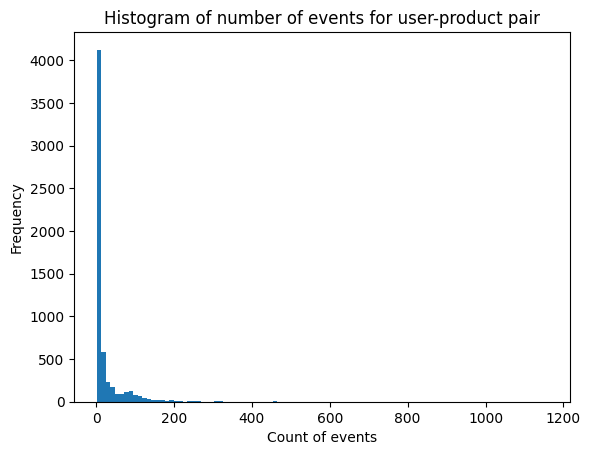

In [53]:
## DISTRIBUTION OF TIME DIFF averaged over ALL interactions  
data_df['TimeDiff'] = data_df.groupby(['Source', 'Destination'])['Timestamp'].diff().dropna()

periodicity_metrics = data_df.groupby(['Source', 'Destination'])['TimeDiff'].agg(['mean', 'std', 'count']).dropna()
periodicity_metrics.sort_values(by='count', inplace=True)
periodicity_metrics


# Assuming periodicity_metrics is your DataFrame and 'count' is a column in that DataFrame
periodicity_metrics['count'].hist(bins=100)

plt.title('Histogram of number of events for user-product pair')
plt.xlabel('Count of events')
plt.ylabel('Frequency')
plt.grid(False)  # Optionally disable the grid for visual clarity
plt.show()

# MOST Source-destination pairs have <1


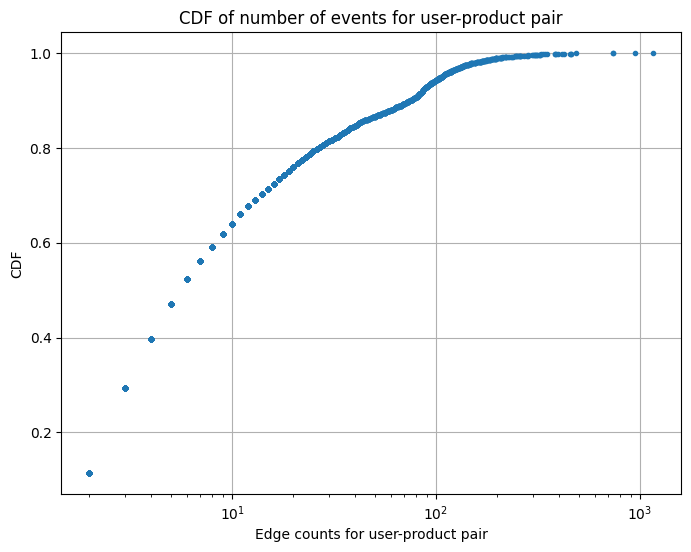

In [54]:
counts_per_user_product = periodicity_metrics['count']

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = counts_per_user_product.reset_index(name='UserProductCount')

plot_cdf(dest_counts_df, 'UserProductCount', log_scale=True, title='CDF of number of events for user-product pair', xlabel='Edge counts for user-product pair', ylabel='CDF')


In [55]:
print(counts_per_user_product.mean())
print(counts_per_user_product.median())
print(counts_per_user_product.max())
print(counts_per_user_product.min())


#62% of user-product pair have 10 or less interactions over the full timeframe...
#The average user-product pair has 23 interactions
#the median user-product pair has 5 interactions



23.02313798344874
5.0
1160
2


For each user-product pair, what HOW DO THE INTERACTIONS CHANGE OVER TIME??

-> the TIME DIFF between interactions integrated over the FULL TIME 


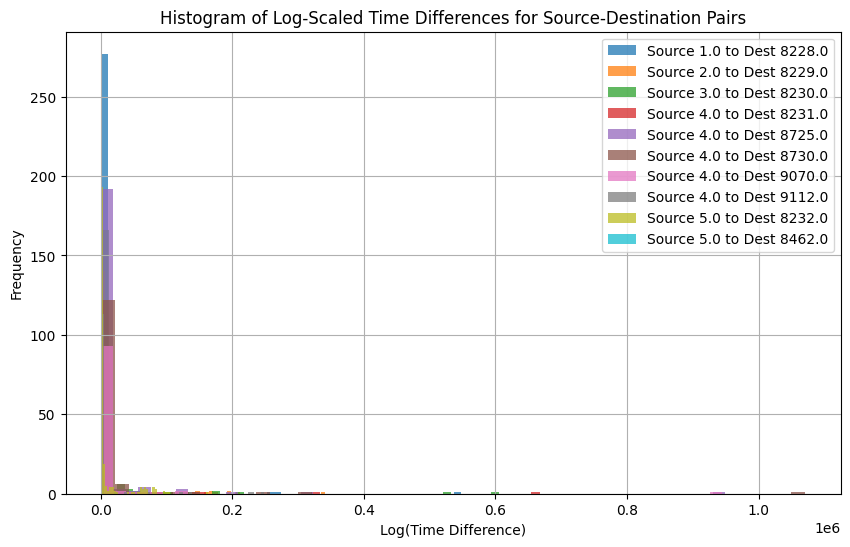

In [120]:


def plot_histogram_for_source_destination_pairs(data_df, max_pairs=None, bins=50, logscale= True, inc_rand = True):
    """
    Plots the histogram of log-scaled TimeDiff for various source-destination pairs.
    
    Parameters:
    - data_df: DataFrame with 'Source', 'Destination', and 'TimeDiff'.
    - max_pairs: Maximum number of source-destination pairs to plot. If None, plot all pairs.
    - bins: Number of bins for the histogram.
    """
    # Group by source and destination
    grouped = data_df.groupby(['Source', 'Destination'])

    # Prepare the plot
    plt.figure(figsize=(10, 6))

    # Counter to limit the number of pairs plotted if max_pairs is set
    pair_count = 0

    for (source, destination), group in grouped:

        time_diffs = group['TimeDiff'].dropna()
        count = len(time_diffs) + 1
        latest_time = group['Timestamp'][-1:]

        
        # Skip any groups without TimeDiff data
        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue

        positive_time_diffs = group['TimeDiff'][group['TimeDiff'] > 0]
        
        if logscale:
            # Filter out non-positive values before log transformation
            
            log_time_diffs = np.log(positive_time_diffs)
            plt.hist(log_time_diffs, bins=bins, label=f'Source {source} to Dest {destination}', alpha=0.75)
        else:
            plt.hist(positive_time_diffs, bins=bins, label=f'Source {source} to Dest {destination}', alpha=0.75)
        
        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break

    if inc_rand:
        plt.hist(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins, 
                 label=f'Random', 
                 alpha=0.75)



    plt.xlabel('Log(Time Difference)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Log-Scaled Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histogram_for_source_destination_pairs(data_df, max_pairs=10, bins=50, logscale=False)


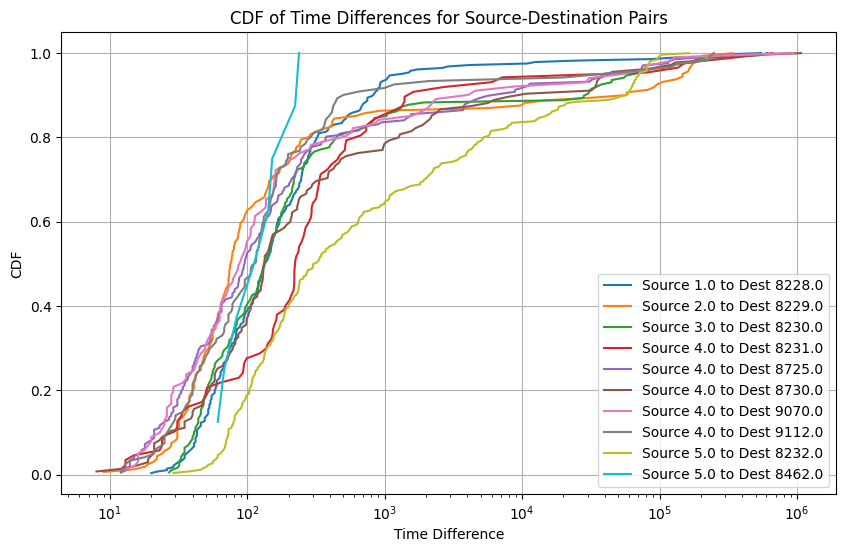

In [116]:

def plot_cdf_for_source_destination_pairs(data_df, max_pairs=None, log_scale=False):
    """
    Plots the CDF of TimeDiff for various source-destination pairs, with an option for logarithmic x-axis.
    
    Parameters:
    - data_df: DataFrame with 'Source', 'Destination', and 'TimeDiff'.
    - max_pairs: Maximum number of source-destination pairs to plot. If None, plot all pairs.
    - log_scale: Boolean to determine if the x-axis should be on a logarithmic scale. Default is False.
    """
    # Group by source and destination
    grouped = data_df.groupby(['Source', 'Destination'])

    # Prepare the plot
    plt.figure(figsize=(10, 6))

    # Counter to limit the number of pairs plotted if max_pairs is set
    pair_count = 0

    for (source, destination), group in grouped:
        # Skip any groups without TimeDiff data
        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue
        
        sorted_time_diffs = np.sort(group['TimeDiff'].dropna().values)
        cdf = np.arange(1, len(sorted_time_diffs) + 1) / len(sorted_time_diffs)

        # Plot
        plt.plot(sorted_time_diffs, cdf, label=f'Source {source} to Dest {destination}')
        
        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break

    if log_scale:
        plt.xscale('log')  # Set the x-axis to a logarithmic scale

    plt.xlabel('Time Difference')
    plt.ylabel('CDF')
    plt.title('CDF of Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_cdf_for_source_destination_pairs(data_df, max_pairs=10, log_scale=True)


/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_28655/1255582204.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


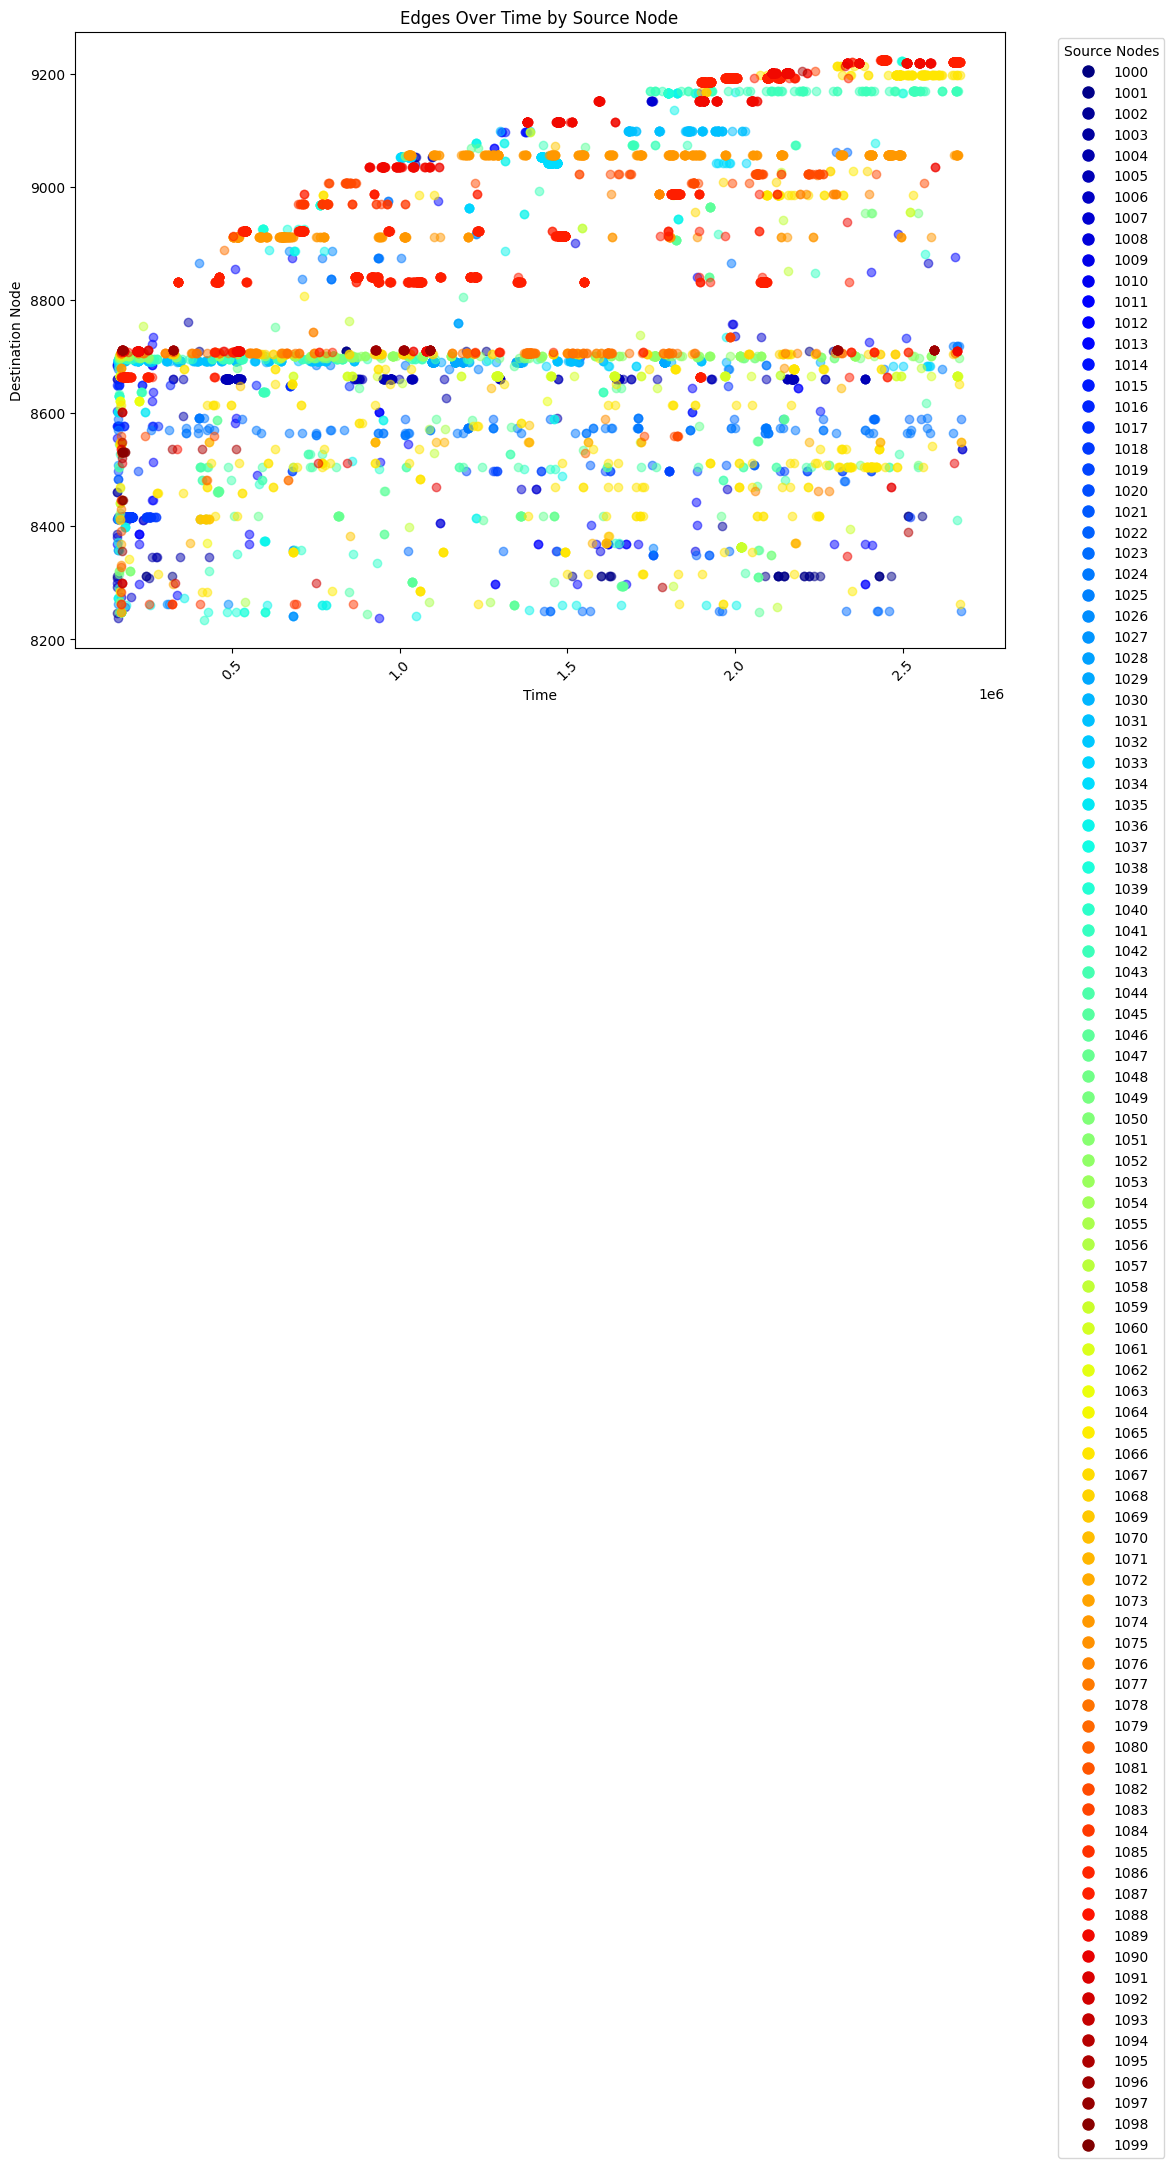

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_edges_over_time_by_source(data_df, source_subset):
    """
    Plots edges over time for a specified subset of source nodes.

    Parameters:
    - data_df: DataFrame containing the columns 'Source', 'Destination', and 'Timestamp'.
    - source_subset: Array-like, the subset of source nodes to include in the plot.
    """
    # Filter the DataFrame for the specified source nodes
    filtered_data = data_df[data_df['Source'].isin(source_subset)].copy()

    # Ensure Timestamp is in datetime format if not already
    # filtered_data['Timestamp'] = pd.to_datetime(filtered_data['Timestamp'])

    # Sort data by timestamp
    filtered_data.sort_values(by='Timestamp', inplace=True)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate a color for each source node in the filtered subset
    colors = plt.cm.jet(np.linspace(0, 1, len(source_subset)))

    # Map each source node to a color
    color_map = {source: color for source, color in zip(source_subset, colors)}

    # Plot each edge, coloring by source node
    for (source, destination), group in filtered_data.groupby(['Source', 'Destination']):
        ax.scatter(group['Timestamp'], [destination] * len(group), color=color_map[source], label=source, alpha=0.5)

    # Create a custom legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=source,
                              markerfacecolor=color, markersize=10)
                       for source, color in color_map.items()]
    ax.legend(handles=legend_elements, title="Source Nodes", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Improve readability of the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Destination Node')
    ax.set_title('Edges Over Time by Source Node')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Assuming 'data_df' is your DataFrame and 'source_subset' is defined
    
source_subset = np.arange(1000, 1100, 1)
plot_edges_over_time_by_source(data_df, source_subset)


In [110]:


# Total Variation Distance function
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

# Hellinger Distance function
def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

def compute_distances(data_df):
    # Group by source and destination
    grouped = data_df.groupby(['Source', 'Destination'])
    
    results = []

    for (source, destination), group in grouped:
        time_diffs = group['TimeDiff'].dropna()
        count = len(time_diffs) + 1
        latest_time = group['Timestamp'][-1:]
        
        # Skip if the group is empty
        if time_diffs.empty:
            continue
        
        bins = int(len(time_diffs))

        # Calculate histogram of the time differences
        counts_p, _ = np.histogram(time_diffs, bins=bins, density=True)
        p = counts_p/sum(counts_p)

        #check metrics as random vs random
        #counts_p, _= np.histogram(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins)
        #p = counts_p/sum(counts_p)

        
        # Generate a random sequence and its histogram of time diff
        counts_q, _ = np.histogram(np.diff(sorted(np.random.uniform(0, int(latest_time), len(time_diffs)))), bins=bins)
        q = counts_q / sum(counts_q)  # Normalize to probabilities

        
        # Compute distances
        tv_distance = total_variation_distance(p, q)
        hellinger = hellinger_distance(p, q)
        
        results.append({
            'Source': source,
            'Destination': destination,
            'Count': count,
            'Total Variation Distance': tv_distance,
            'Hellinger Distance': hellinger
        })
    
    results_df = pd.DataFrame(results)

    return results_df


In [111]:
# Example usage
results_df = compute_distances(data_df)


/var/folders/53/d8br5nln6vq67q925j2wx6kc0000gn/T/ipykernel_91743/4046941313.py:37: RuntimeWarning: invalid value encountered in divide
  q = counts_q / sum(counts_q)  # Normalize to probabilities


In [112]:
results_df = results_df[results_df['Count'] >100]


In [113]:
results_df

,Source,Destination,Count,Total Variation Distance,Hellinger Distance
0,1.0,8228.0,285,0.929465,0.871775
1,2.0,8229.0,162,0.894216,0.866587
2,3.0,8230.0,189,0.850808,0.803173
4,4.0,8725.0,208,0.850054,0.805089
5,4.0,8730.0,136,0.829132,0.777313
...,...,...,...,...,...
8203,6768.0,9191.0,148,0.767822,0.736536
8217,6790.0,8861.0,109,0.814036,0.804941
8251,6862.0,9196.0,198,0.791257,0.762739
8549,7522.0,9213.0,127,0.864571,0.823088


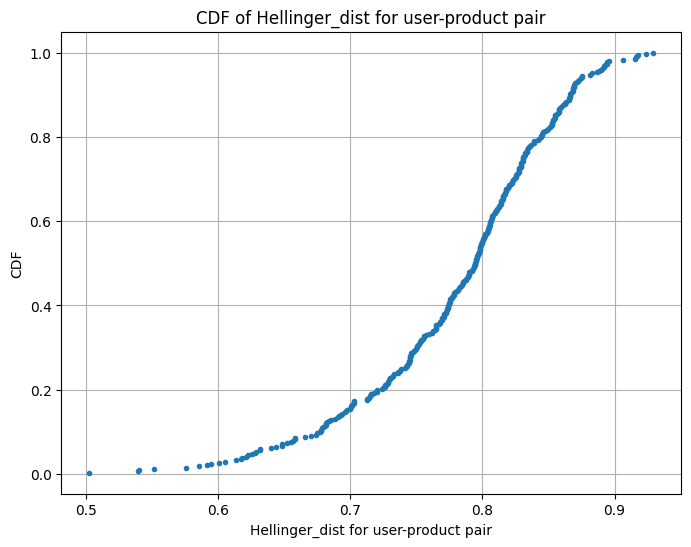

In [114]:

Hellinger_dist = results_df['Hellinger Distance']

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = Hellinger_dist.reset_index(name='Hellinger_dist')

plot_cdf(dest_counts_df, 'Hellinger_dist', log_scale=False, title='CDF of Hellinger_dist for user-product pair', xlabel='Hellinger_dist for user-product pair', ylabel='CDF')


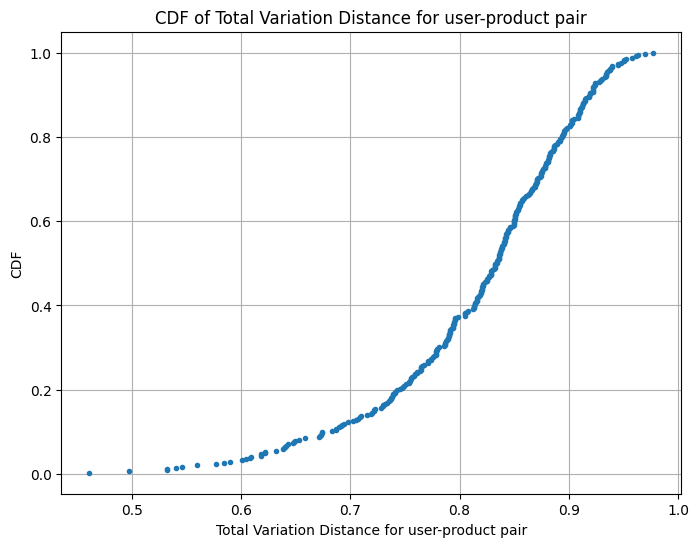

In [115]:



Total_Variation_Distance = results_df['Total Variation Distance']

# Convert the series to a DataFrame for easier manipulation
dest_counts_df = Total_Variation_Distance.reset_index(name='Total Variation Distance')

plot_cdf(dest_counts_df, 'Total Variation Distance', log_scale=False, title='CDF of Total Variation Distance for user-product pair', xlabel='Total Variation Distance for user-product pair', ylabel='CDF')


In [98]:


filtered_results_df = results_df[results_df['Total Variation Distance'] >0.9]
source_subset = filtered_results_df['Source'].unique()

plot_edges_over_time_by_source(data_df, source_subset)


NameError: name 'plot_edges_over_time_by_source' is not defined

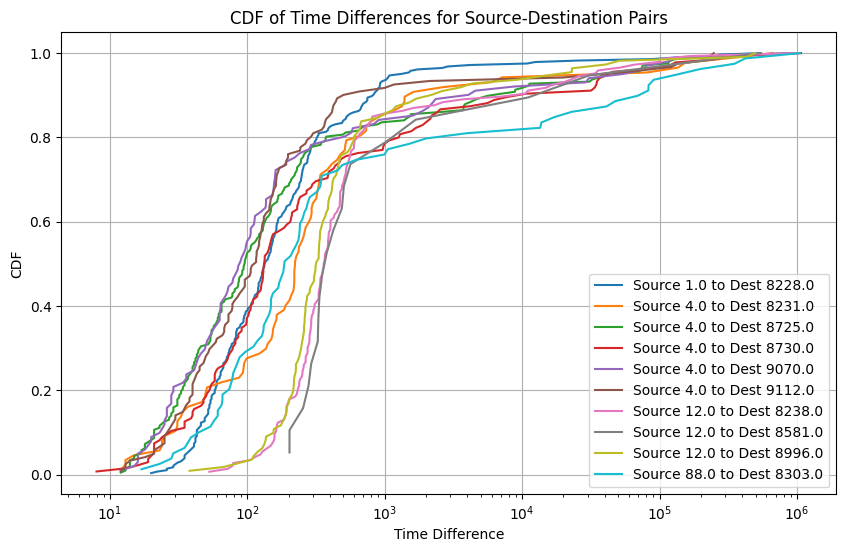

In [141]:

filtered_data_df = data_df[data_df['Source'].isin(source_subset)]

# Now call the plot_cdf_for_source_destination_pairs function with the filtered DataFrame
plot_cdf_for_source_destination_pairs(filtered_data_df, max_pairs=10, log_scale=True)

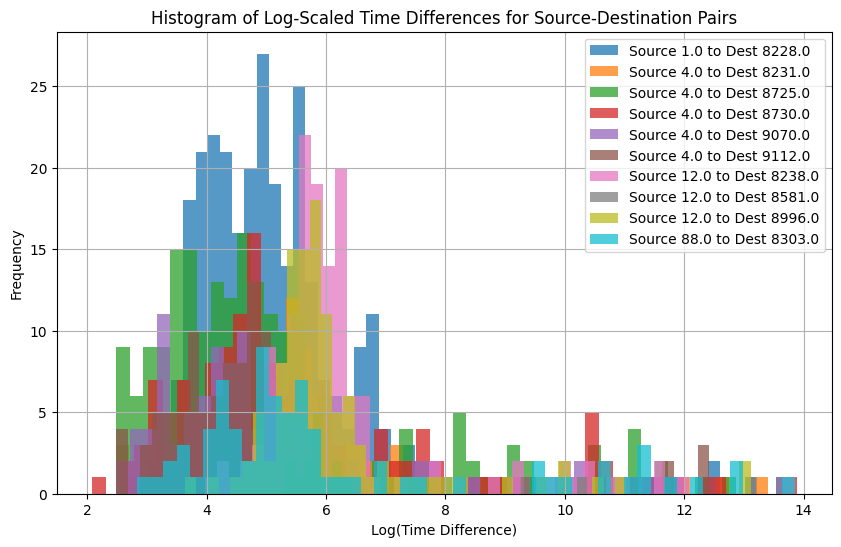

In [129]:
plot_histogram_for_source_destination_pairs_log_scale(filtered_data_df, max_pairs=10, bins=50)


In [137]:


def plot_histogram_with_random_sequence(data_df, max_pairs=None, bins=50, log_scale=False, include_random=False):
    """
    Plots the histogram of TimeDiff for various source-destination pairs, with optional log scaling and random sequence comparison.
    
    Parameters:
    - data_df: DataFrame with 'Source', 'Destination', and 'TimeDiff'.
    - max_pairs: Maximum number of source-destination pairs to plot. If None, plot all pairs.
    - bins: Number of bins for the histogram.
    - log_scale: Boolean, applies a logarithmic scale to the x-axis if True.
    - include_random: Boolean, includes a histogram of a random uniform sequence if True.
    """
    grouped = data_df.groupby(['Source', 'Destination'])
    plt.figure(figsize=(10, 6))
    pair_count = 0

    for (source, destination), group in grouped:
        if 'TimeDiff' not in group or group['TimeDiff'].isnull().all():
            continue
        
        time_diffs = group['TimeDiff'].dropna()
        
        if include_random:
            random_seq = sorted(np.random.uniform(low=time_diffs.min(), high=time_diffs.max(), size=len(time_diffs)))

            plt.hist(np.diff(random_seq), bins=bins, color='black', alpha=0.5, label='Random Uniform' if pair_count == 0 else "", density=True)

        plt.hist(time_diffs, bins=bins, alpha=0.75, label=f'Source {source} to Dest {destination}', density=True)
        
        pair_count += 1
        if max_pairs is not None and pair_count >= max_pairs:
            break

    if log_scale:
        plt.xscale('log')

    plt.xlabel('Time Difference')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Differences for Source-Destination Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()


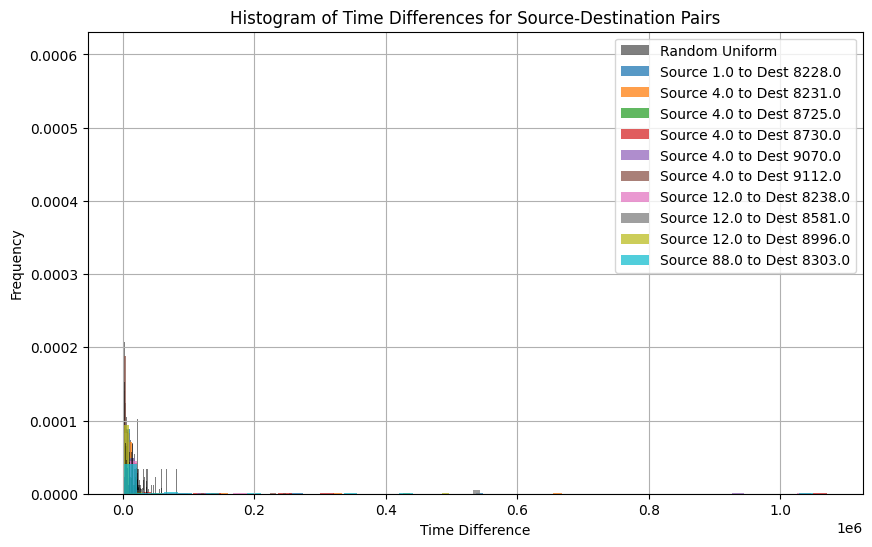

In [143]:
plot_histogram_with_random_sequence(filtered_data_df,max_pairs=10, bins=50, log_scale=False, include_random=True)

### Download the TGL datasets

In [9]:
data_urls = DATA_URL_DICT
data_urls

{'tgbl-wiki': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-wiki-v2.zip',
 'tgbl-review': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-review-v2.zip',
 'tgbl-coin': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-coin-v2.zip',
 'tgbl-flight': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-flight-v2.zip',
 'tgbl-comment': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbl-comment.zip',
 'tgbn-trade': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-trade.zip',
 'tgbn-genre': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-genre.zip',
 'tgbn-reddit': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-reddit.zip',
 'tgbn-token': 'https://object-arbutus.cloud.computecanada.ca/tgb/tgbn-token.zip'}

In [14]:
import os
import requests
import zipfile

def download_and_unzip(url, extract_to='.'):
    """
    Download a ZIP file from a specified URL and extract its contents to a specified directory
    only if the ZIP file hasn't been extracted there before.
    
    Parameters:
    - url: The URL of the ZIP file to download.
    - extract_to: The directory to extract the contents of the ZIP file. Defaults to the current directory.
    """
    # Ensure the extract_to directory exists
    os.makedirs(extract_to, exist_ok=True)

    # Get the name of the file
    filename = url.split('/')[-1]
    zip_path = os.path.join(extract_to, filename)

    # Check if the file or directory already exists to avoid re-downloading and re-extracting
    if os.path.exists(zip_path):  # You might need a more robust check here
        print(f"{filename} already exists in {extract_to}. Skipping download and extraction.")
        return

    # Download the file
    print(f"Downloading {filename}...")
    response = requests.get(url)
    response.raise_for_status()  # Check if the download was successful

    # Save the file to the current directory
    with open(zip_path, 'wb') as zip_file:
        zip_file.write(response.content)
    print(f"Downloaded {filename}.")

    # Unzip the file
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {filename} to {extract_to}.")

    # Optionally, remove the ZIP file after extraction
    os.remove(zip_path)
    print(f"Removed {filename}.")

# Example usage
# url = "https://example.com/path/to/your/zipfile.zip"
# download_and_unzip(url, 'path/to/extract/directory')


In [15]:
for _, link in data_urls.items():
    download_and_unzip(link, './GDL_project_HQ/Data')
    #pass

KeyboardInterrupt: 

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdf_np(data):
    """
    Plots the Cumulative Distribution Function (CDF) for the given dataset.

    Parameters:
    - data: An array-like sequence of data points.
    """
    # Sort the data
    sorted_data = np.sort(data)
    
    # Compute the CDF values
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Plotting the CDF
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_data, cdf, marker='.', linestyle='none')
    plt.title('Cumulative Distribution Function (CDF) of the Data')
    plt.xlabel('Data value')
    plt.ylabel('CDF value')
    plt.grid(True)
    plt.show()


### Metrics for periodic time series 

In this section I am trying to come up with an edge based metric for periodicity. 

Methods like the Fourier transform are useful when there is both a timestamp and a value associated with it: imagine a superimposed combinatino of different frequency waves which can be decomposed into their basis frequencies. 

However, it does not work well for just timestamps without any values, which is the kind of data we are likely to get.
In reality even if the data has values associated with it, like in the Wiki dataset, they are vectors for words which seems like converting to a real number between -1 and 1 isn't that meaningful. 


#### Generating data

To test the periodicity we need examples that get progressively more difficult. 
To make it increasingly difficult I look at 3 variables: number of 'channels', and noise. 

Noise:
- uniform distribution that can alter the exact value of a specific timepoint within a certain window
- can also pick normal distribution as easier noise

Channels
- regular 1 channel, 0 noise: i.e. 0,3,6,9,12, ... 
- regular 1 channel, small gaussian noise i.e. 0.1, 3.2, 5.8, 8.9, 12.2
- regular 1 channel, small uniform noise 

- 2 channels, 0 noise:
    first channel: multiples of 3, 
    second channel: multiples of 7
    total: 0,3, 6, 7, 9, 12, 14, 15, ... 



In [9]:
def generate_arithmetic_seq(gaps:list, 
                            noise_var:int, 
                            total_points:int):
    # gaps: the arithmetic summation gap for each channel
    # noise_var: the integer value describing the max +/- range that is used for uniform distribution 
    # total_points: how long the final sequence needs to be 
    # return: the sequence, sorted and filtered to specific length 
    
    sequences = []
    for c in range(len(gaps)):
        if c==0:
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(total_points)])
        else:
            max_value= sequences[0][-1]
            #print(sequences[0][-1])
            new_total_points = int(max_value/gaps[c])
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(new_total_points)])

    sequences = list(itertools.chain.from_iterable(sequences))
    sequences = sorted(sequences)[:total_points]

    return(sequences)
        

In [35]:
random_seq = sorted(np.random.uniform(0, 1000, 1000))

In [13]:
seq = generate_arithmetic_seq([5], 5, 100)


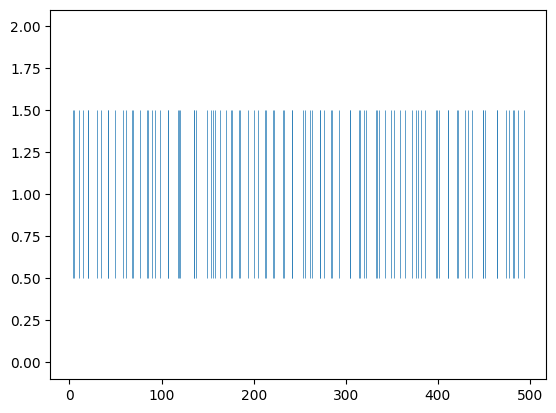

In [37]:
plt.eventplot(seq, linewidths=0.5)

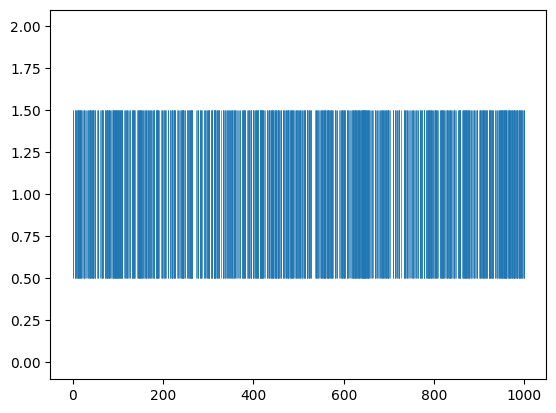

In [36]:
plt.eventplot(random_seq, linewidths=0.5)

#### Metrics for periodicity

Ok this is the first hard bit...

if we have a rhyhthm, how do we think quantifying its periodicity?

on one extreme we have random/white noise, where no event can tell us about the sequence
on the other we have something extremely regular, where after 2 or 3 or 4 we could have a good guess of continuing correctly

The idea of entropy or surprise comes to mind: given we have 3 points, how surprised would we be about the 4th?

I don't have much clue about how to think about this from an information theory perspective... would need help!


Starting simple however:

1) Take the diffrence of the points. 
- The difference of a completely random distribution should at its limit go towards a gaussian as per central limit theorm. The gaussian will bound to be positive. 
- The difference within a noiseless series should be very high at specific peak
- if there is a small amount of noise around each peak this suggests some minor noise 
=> this last bit reminds of maybe signal to noise quantification. If we have a 0 noise periodic pattern, the signal to noise should be very high and lower otherwise. 


2) OR could try to see how SIMILAR the distribution of a completely random one is to a non-random!! with a KL divergence?? or a wasserstein distance?




In [38]:
sample_sequences = {'random': random_seq,
             'single_no_noise': generate_arithmetic_seq([3], 0, 100),
             'single_noise': generate_arithmetic_seq([3], 0.1, 100),
             'double_no_noise': generate_arithmetic_seq([3,8], 0, 100),
             'double_noise': generate_arithmetic_seq([3,8], 0.1, 100),
             'double_med_noise': generate_arithmetic_seq([3,8], 1, 100),
             'double_large_noise': generate_arithmetic_seq([3,8], 10, 100)

}

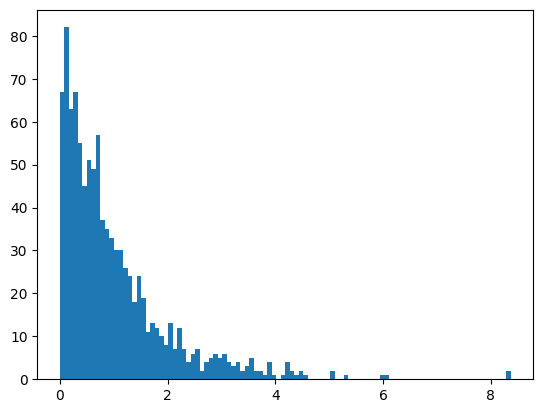

In [39]:
res = plt.hist(np.diff(random_seq), bins=len(seq))


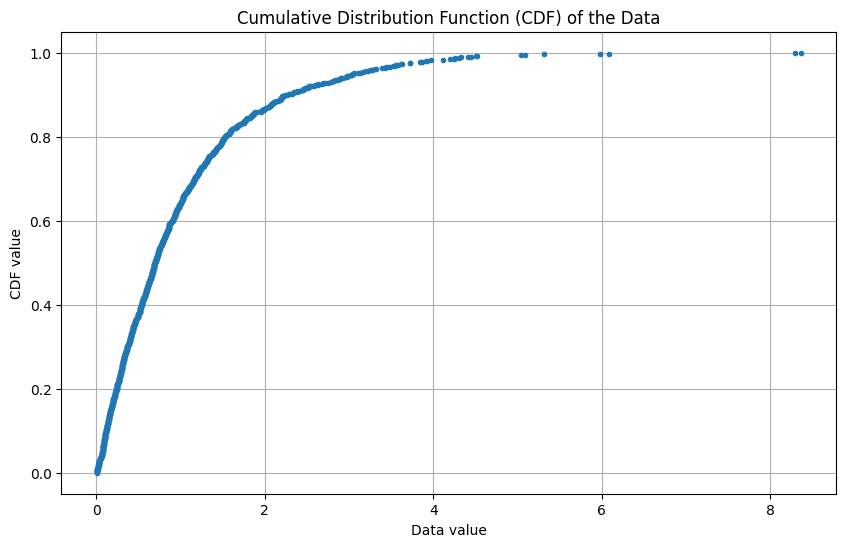

In [103]:
plot_cdf_np(np.diff(random_seq))

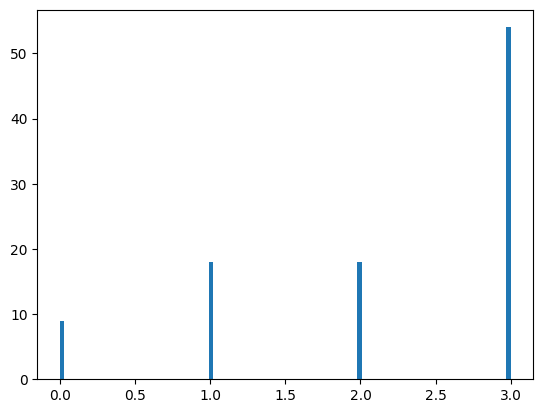

In [104]:
seq = generate_arithmetic_seq([3,8], 0, 100)
res = plt.hist(np.diff(seq), bins=len(seq))


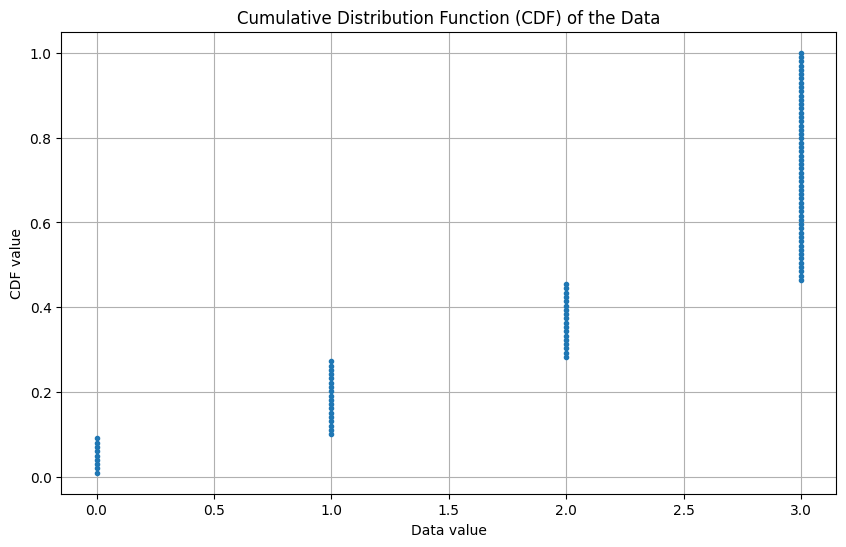

In [105]:
plot_cdf_np(np.diff(seq))

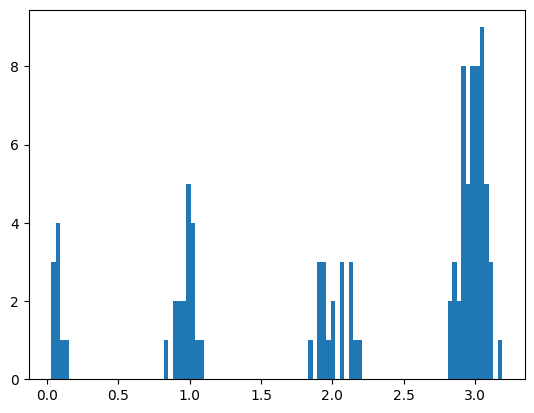

In [106]:
seq = generate_arithmetic_seq([3,8], 0.1, 100)
res = plt.hist(np.diff(seq), bins=len(seq))


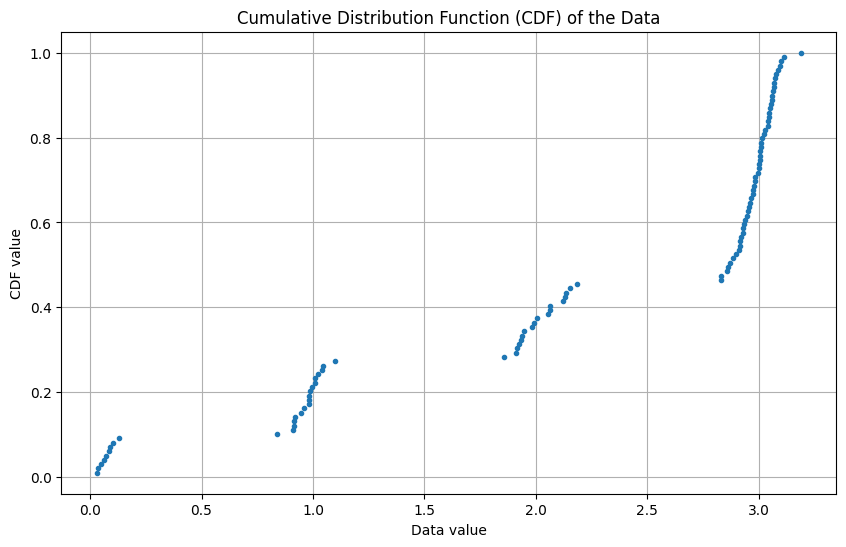

In [107]:
plot_cdf_np(np.diff(seq))

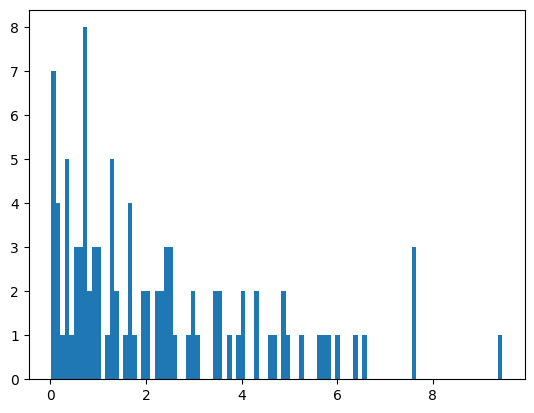

In [108]:
seq = generate_arithmetic_seq([3,8], 10, 100)
res = plt.hist(np.diff(seq), bins=len(seq))


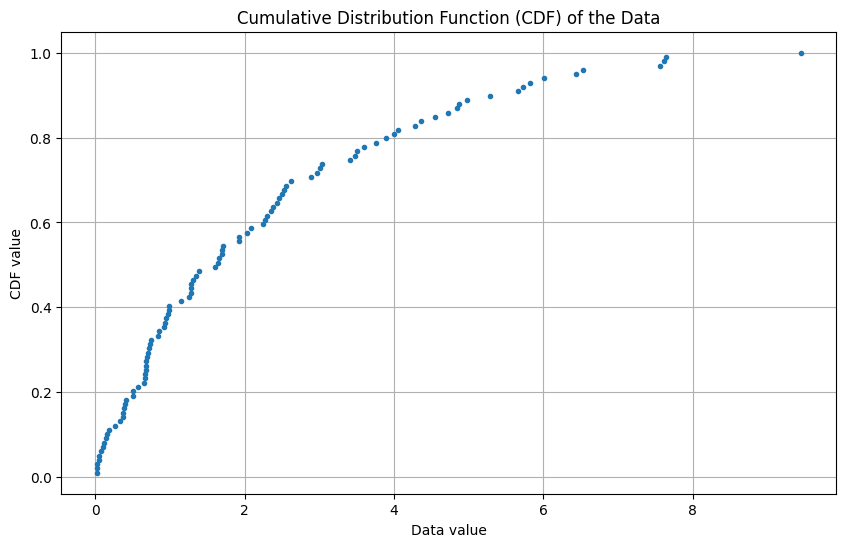

In [109]:
plot_cdf_np(np.diff(seq))

**Simple metrics from difference**

We can start by comparing the variance of the differences amongst the values.. 

In [60]:
def seq_diff_variance (sequence):
    # Calculate differences between consecutive numbers
    differences = np.diff(sequence)
    
    # Calculate the variance of these differences
    variance_of_differences = np.var(differences)
    
    # The higher the variance, the higher the 'entropy'
    return variance_of_differences
# Example sequence with regular intervals


In [69]:
for key, value in sample_sequences.items():
    print(f'{key}: {seq_diff_variance(value)}')

random: 1.1683608409392499
single_no_noise: 0.0
single_noise: 0.0071972791439991425
double_no_noise: 1.0578512396694213
double_noise: 1.0512413610676197
double_med_noise: 1.3220273231828985
double_large_noise: 4.307135735242676


That does not work very well..

How about we try the distance between the random diff distribution and each one? 

In [107]:
# Example of computing distances between two discrete distributions p and q
def kl_divergence(p, q):
    """Compute KL Divergence between two distributions."""
    return np.sum(rel_entr(p, q))

def js_divergence(p, q):
    """Symmetric measure, derived from KL Divergence."""
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def js_distance(p, q):
    return np.sqrt(js_divergence(p, q))

# Total Variation Distance
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

# Hellinger Distance
def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Wasserstein Distance (Earth Mover’s Distance)
def wasserstein_distance_wrapper(p, q, bins_p, bins_q):
    # Calculate the midpoints of the bins for both distributions
    midpoints_p = 0.5 * (bins_p[:-1] + bins_p[1:])
    midpoints_q = 0.5 * (bins_q[:-1] + bins_q[1:])
    
    # Use the counts as weights for the Wasserstein distance
    return wasserstein_distance(midpoints_p, midpoints_q, p, q)




In [112]:
methods = [
    kl_divergence,
    js_divergence,
    js_distance,
    total_variation_distance,
    hellinger_distance,
    wasserstein_distance_wrapper
]

# Correct DataFrame initialization using method objects
df = pd.DataFrame(index=[method.__name__ for method in methods], columns=sample_sequences.keys())

# Reference distribution p calculation
counts_p, bins_p = np.histogram(np.diff(sorted(np.random.uniform(0, 100, 100))), bins=len(random_seq))
p = counts_p / sum(counts_p)  # Normalize to probabilities

# Iterate through sequences and methods
for k, v in sample_sequences.items():
    counts_v, bins_v = np.histogram(np.diff(v), bins=len(v))
    q = counts_v / sum(counts_v)  # Normalize to probabilities

    for method in methods:
        # Special handling for wasserstein_distance_wrapper due to additional arguments
        if method.__name__ == 'wasserstein_distance_wrapper':
            try:
                result = method(p, q, bins_p, bins_v)
            except ValueError as e:
                result = np.nan  # Handle incompatible dimensions
        else:
            try:
                result = method(p, q)
            except ValueError as e:
                result = np.nan  # Handle incompatible dimensions
        
        df.loc[method.__name__, k] = result



In [113]:
df

,random,single_no_noise,single_noise,double_no_noise,double_noise,double_med_noise,double_large_noise
kl_divergence,inf,inf,inf,inf,inf,inf,inf
js_divergence,0.243532,0.693147,0.394988,0.621777,0.494407,0.342383,0.247182
js_distance,0.493489,0.832555,0.62848,0.788528,0.703141,0.585135,0.497174
total_variation_distance,0.494949,1.0,0.666667,0.959596,0.777778,0.59596,0.484848
hellinger_distance,0.573649,1.0,0.743583,0.91655,0.838416,0.691762,0.580676
wasserstein_distance_wrapper,0.196905,2.053457,2.03799,1.239105,1.227551,1.175657,1.190734


TOTAL_VARIATION_DISTANCE ad Hellinger distance both seem good options.
now we need to validate these and try them over a varying set of sequences

1) do they give the same value regardless of where the 'diff' is?
2) what if the top diff value is huge or very small?


We also haven't really looked at metrics such as:
- **Gap size** (what proportion of edges have gaps that are v close vs far away)
- **Continuous vs intermittent**
- **Clusters or not**

for example, the interaction could be clusters of 10 or so, then large gap, then cluster again 


**This way we can split node-node interactions by the TYPE of temporal edge recurrence they have!**

1) we need to adjust the data generation function to start having a look at these other patterns.
2) come up with metrics for each of these






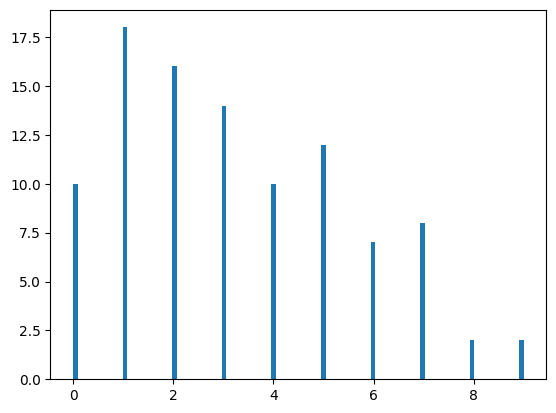

In [140]:
seq = generate_arithmetic_seq([9,10,11], 0, 100)
#plt.eventplot(seq)
res = plt.hist(np.diff(seq), bins=len(seq))


## Inference and generation

The metrics above give an overall sense if a timeseries is random or regular, but do not give further indication on the regularity.
For example:
- what IS the pattern? and the noise associated with it?


Ultimately the generative aim is to be able to infer from the timeseries data what is going to happen next!
One way to do this is to do a Maximum Likelihood on the data generating parameters i.e. one vs multi channel, gap, noise...
A fully bayesian method would also give a prior on sequences and therefore a full posterior distribution on the parameters.

Once inference is achieved, the model can continue the sequence (and do link prediction) with minimal errors. 
This is ultimately what we want our GNN model to do: 
- as a sequence is starting, come up with possible latents (that may themselves move over time) that describe the sequence generating function 
- this function needs to take into account the previous data, and the one/multi hop interactions of that node with other edges. 
    For example, a BURST of edges at a between multiplen nodes that can be predicted by the interaction between neighbouring nodes just preceding it


This allows for each node-node to have 





In [488]:
def generate_arithmetic_seq(gaps, noise_var, total_points):
    
    sequences = []
    for c in range(len(gaps)):
        if c==0:
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(total_points)])
        else:
            max_value= sequences[0][-1]
            #print(sequences[0][-1])
            new_total_points = int(max_value/gaps[c])
            sequences.append([(0+i*gaps[c])+np.random.uniform(-noise_var, noise_var) for i in range(new_total_points)])

    sequences = list(itertools.chain.from_iterable(sequences))
    sequences = sorted(sequences)[:total_points]

    return(sequences)
        

In [519]:

def generate_combinations(elements):
    all_combinations = []
    for r in range(1, len(elements) + 1):
        # Generate and append combinations of length r
        all_combinations.extend([list(comb) for comb in combinations(elements, r)])
    return all_combinations

elements = range(10)
combinations_output = generate_combinations(elements)
combinations_output

total_data = []

for i in combinations_output:
    for j in range(20):
        total_data.append(generate_arithmetic_seq(i, 0, 100))

In [520]:
len(total_data)

20460

In [526]:
total_data[0]

[0.0,
 0.0,
 0.0,
 2.0,
 4.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 12.0,
 14.0,
 14.0,
 16.0,
 18.0,
 18.0,
 20.0,
 21.0,
 22.0,
 24.0,
 26.0,
 27.0,
 28.0,
 28.0,
 30.0,
 32.0,
 34.0,
 35.0,
 36.0,
 36.0,
 38.0,
 40.0,
 42.0,
 42.0,
 44.0,
 45.0,
 46.0,
 48.0,
 49.0,
 50.0,
 52.0,
 54.0,
 54.0,
 56.0,
 56.0,
 58.0,
 60.0,
 62.0,
 63.0,
 63.0,
 64.0,
 66.0,
 68.0,
 70.0,
 70.0,
 72.0,
 72.0,
 74.0,
 76.0,
 77.0,
 78.0,
 80.0,
 81.0,
 82.0,
 84.0,
 84.0,
 86.0,
 88.0,
 90.0,
 90.0,
 91.0,
 92.0,
 94.0,
 96.0,
 98.0,
 98.0,
 99.0,
 100.0,
 102.0,
 104.0,
 105.0,
 106.0,
 108.0,
 108.0,
 110.0,
 112.0,
 112.0,
 114.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 122.0,
 124.0,
 126.0,
 126.0,
 126.0,
 128.0,
 130.0]

In [493]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ImprovedSequenceModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=F.relu, dropout_rate=0.5):
        super(ImprovedSequenceModel, self).__init__()
        
        self.activation_fn = activation_fn
        
        # Dynamically create hidden layers
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        self.output_layer = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = self.activation_fn(layer(x))
            else:
                x = layer(x)
        x = self.output_layer(x)
        return x

# Model instantiation
input_size = 70  # Input sequence length
hidden_size = [64]  # Hidden layers size
output_size = 30  # Output sequence length (continuation)

model = ImprovedSequenceModel(input_size, hidden_size, output_size)

# Check if a GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


ImprovedSequenceModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=70, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=30, bias=True)
)


In [525]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

class TransformerSequenceModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, nhead=6, num_layers=2, dropout=0.2):
        super(TransformerSequenceModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Transformer encoder layers
        encoder_layers = TransformerEncoderLayer(d_model=input_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Transformer decoder layers
        decoder_layers = TransformerDecoderLayer(d_model=input_size, nhead=nhead, dropout=dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, num_layers=num_layers)
        
        # Fully connected output layer
        self.fc_output = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        # Transformer encoder
        encoder_output = self.transformer_encoder(x)
        
        # Transformer decoder (use encoder_output as memory)
        decoder_output = self.transformer_decoder(x, encoder_output)
        
        # Fully connected output layer
        x = self.fc_output(decoder_output[:, -1, :])  # Take the output of the last time step
        return x

    

# Model instantiation
input_size = 70  # Input sequence length
hidden_size = 64  # Hidden layers size
output_size = 30  # Output sequence length (continuation)

model = TransformerSequenceModel(input_size, hidden_size, output_size)

# Check if a GPU is available and move the model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


AssertionError: embed_dim must be divisible by num_heads

In [521]:
# Mock data preparation for demonstration
import random
import torch

# Assuming total_data is a list of lists where each inner list represents a sequence

# Parameters for mock dataset
num_samples = len(total_data)  # Number of samples in the dataset
sequence_length = input_size  # Length of each input sequence
continuation_length = output_size  # Length of each sequence continuation (target)

# Generate mock data
random.seed(0)  # For reproducibility
random.shuffle(total_data)  # Shuffle the data

# Extract input and target sequences
inputs = torch.tensor([seq[:sequence_length] for seq in total_data], dtype=torch.float32)
targets = torch.tensor([seq[sequence_length:sequence_length + continuation_length] for seq in total_data], dtype=torch.float32)

# Split the dataset into training, validation, and test sets
train_size = int(num_samples * 0.7)
val_size = int(num_samples * 0.2)
test_size = num_samples - train_size - val_size

train_dataset = torch.utils.data.TensorDataset(inputs[:train_size], targets[:train_size])
val_dataset = torch.utils.data.TensorDataset(inputs[train_size:train_size + val_size], targets[train_size:train_size + val_size])
test_dataset = torch.utils.data.TensorDataset(inputs[train_size + val_size:], targets[train_size + val_size:])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [522]:

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified for demonstration)
epochs = 100
model.train()  # Set model to training mode

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Zero the parameter gradients
        #print(inputs)
        outputs = model(inputs)  # Forward pass
        #print(outputs)
        #print(targets)
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Note: This is a simplified example. Proper training would include validation checks, saving the model, etc.


Epoch 1, Loss: 3002.3829197628156
Epoch 2, Loss: 2981.1547370808466
Epoch 3, Loss: 2959.259830440794
Epoch 4, Loss: 2968.2493321384704
Epoch 5, Loss: 2972.9495778765
Epoch 6, Loss: 2977.5738226345607
Epoch 7, Loss: 2975.2912963543617
Epoch 8, Loss: 2964.2260911294393
Epoch 9, Loss: 2962.951973267964
Epoch 10, Loss: 2975.6566598415375
Epoch 11, Loss: 2952.368497303554
Epoch 12, Loss: 2982.6749070116452
Epoch 13, Loss: 2959.7568729604995
Epoch 14, Loss: 3001.1800299371994
Epoch 15, Loss: 2941.9159529379435
Epoch 16, Loss: 2975.356298310416
Epoch 17, Loss: 2956.3104259627207
Epoch 18, Loss: 2956.4395711592265
Epoch 19, Loss: 2961.1953397137777
Epoch 20, Loss: 2965.3370889595576
Epoch 21, Loss: 2973.2429046801158
Epoch 22, Loss: 2973.177636929921
Epoch 23, Loss: 3005.1512049393996
Epoch 24, Loss: 2971.446056127548
Epoch 25, Loss: 2967.931470828397
Epoch 26, Loss: 2992.4588436228887
Epoch 27, Loss: 2987.3850219249725
Epoch 28, Loss: 2968.1591806071146
Epoch 29, Loss: 2984.2222350495204
Epoc

KeyboardInterrupt: 